In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
import pandas_datareader
import pandas_datareader.data as web
from pandas import DataFrame
import yfinance as yfin
yfin.pdr_override()
import sys
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [4]:
start= datetime.datetime.now() - datetime.timedelta(days=10*365)
end=datetime.datetime.now()
AMD = web.get_data_yahoo('AMD', start, end)
AMD.to_csv('AMD_Stock.csv')
print(AMD.shape)
print(AMD.tail())

[*********************100%***********************]  1 of 1 completed
(2516, 6)
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-12-31  146.160004  148.610001  143.550003  143.899994  143.899994   
2022-01-03  145.139999  151.649994  145.020004  150.240005  150.240005   
2022-01-04  151.009995  152.419998  140.699997  144.419998  144.419998   
2022-01-05  142.820007  143.759995  135.289993  136.149994  136.149994   
2022-01-06  136.190002  138.000000  131.770004  136.229996  136.229996   

              Volume  
Date                  
2021-12-31  49416000  
2022-01-03  59396600  
2022-01-04  80200500  
2022-01-05  65403200  
2022-01-06  64676600  


2021-11-30 00:00:00
163.27999877929688


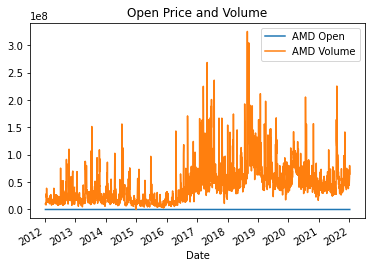

In [5]:
AMD['Open'].plot(label="AMD Open",title='Open Price and Volume');
AMD['Volume'].plot(label='AMD Volume');
plt.legend();
print(AMD['Open'].idxmax())
print(AMD['Open'].max())

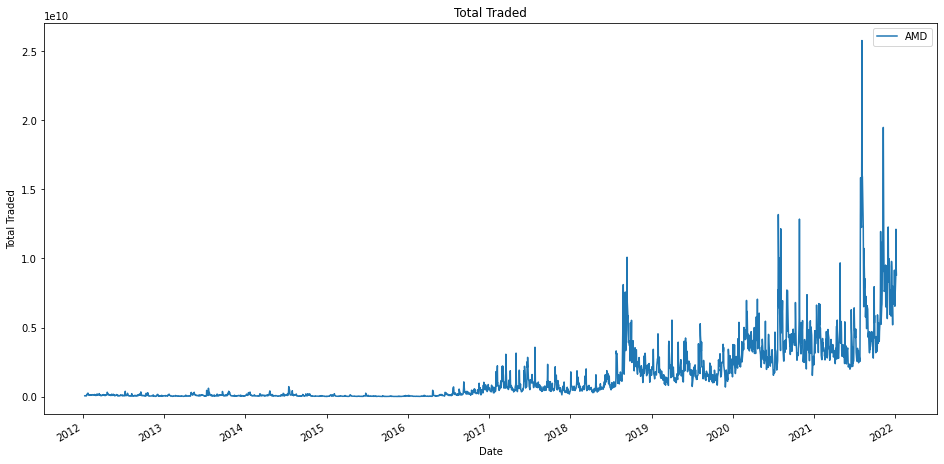

In [6]:
AMD['Total Traded'] = AMD['Open']*AMD['Volume']
AMD['Total Traded'].plot(label='AMD',figsize=(16,8),title='Total Traded')
plt.legend()
plt.ylabel('Total Traded');

In [7]:
test_result=adfuller(AMD['Open'])

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
adfuller_test(AMD['Open'])

ADF Test Statistic : 1.9802748590952985
p-value : 0.9986467657290159
#Lags Used : 27
Number of Observations Used : 2488
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<IPython.core.display.Javascript object>


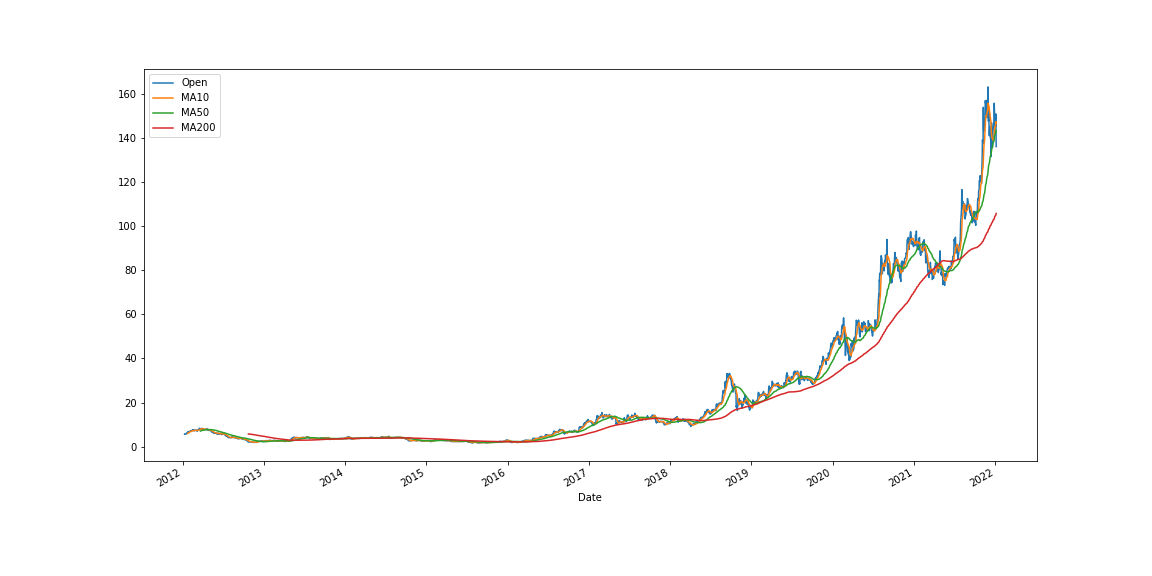

<AxesSubplot:xlabel='Date'>

In [8]:
%matplotlib notebook
AMD['MA10'] = AMD['Open'].rolling(10).mean()
AMD['MA50'] = AMD['Open'].rolling(50).mean()
AMD['MA200'] = AMD['Open'].rolling(200).mean()
AMD[['Open','MA10','MA50','MA200']].plot(label='gm',figsize=(16,8))

<IPython.core.display.Javascript object>


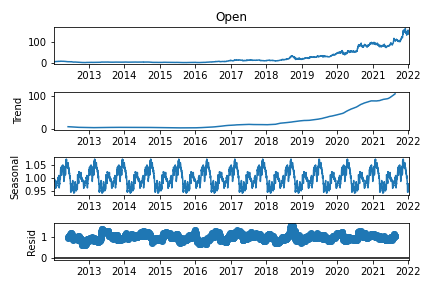

<IPython.core.display.Javascript object>


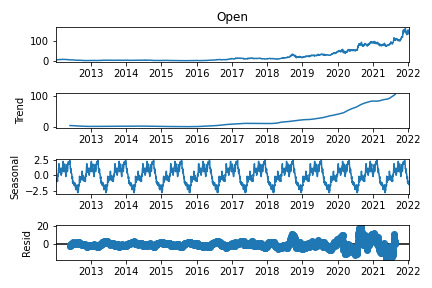

In [9]:
decompose_result = seasonal_decompose(AMD['Open'],model='multiplicative', period=199)
decompose_result.plot();
decompose_result = seasonal_decompose(AMD['Open'],model='additive', period=199)
decompose_result.plot();

<IPython.core.display.Javascript object>


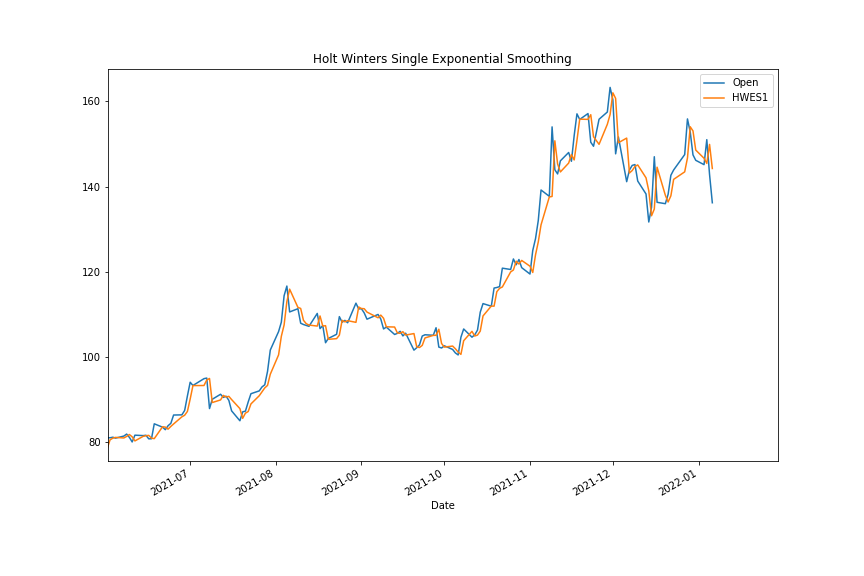

<AxesSubplot:title={'center':'Holt Winters Single Exponential Smoothing'}, xlabel='Date'>

In [10]:
%matplotlib notebook
alpha = 0.8
AMD['HWES1'] = SimpleExpSmoothing(AMD['Open']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
AMD[['Open','HWES1']].plot(figsize=(12,8),title='Holt Winters Single Exponential Smoothing')

<IPython.core.display.Javascript object>


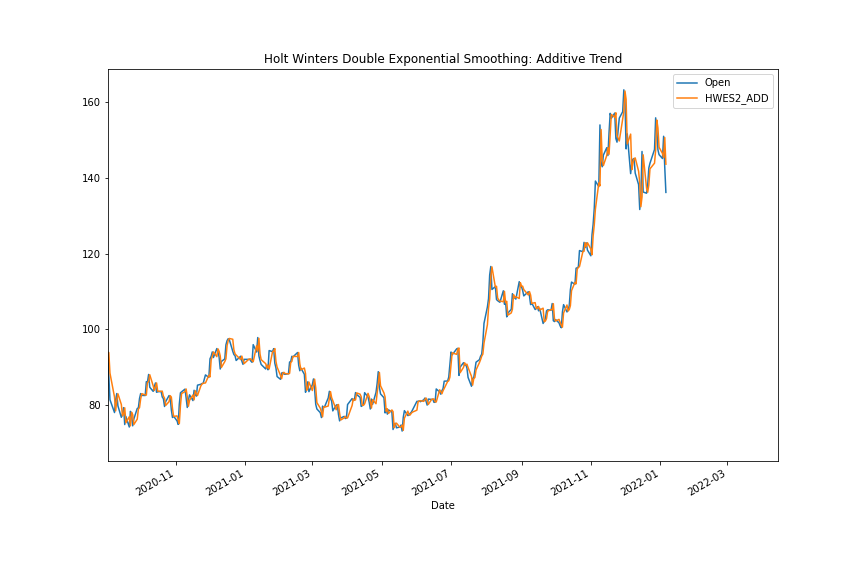

<IPython.core.display.Javascript object>


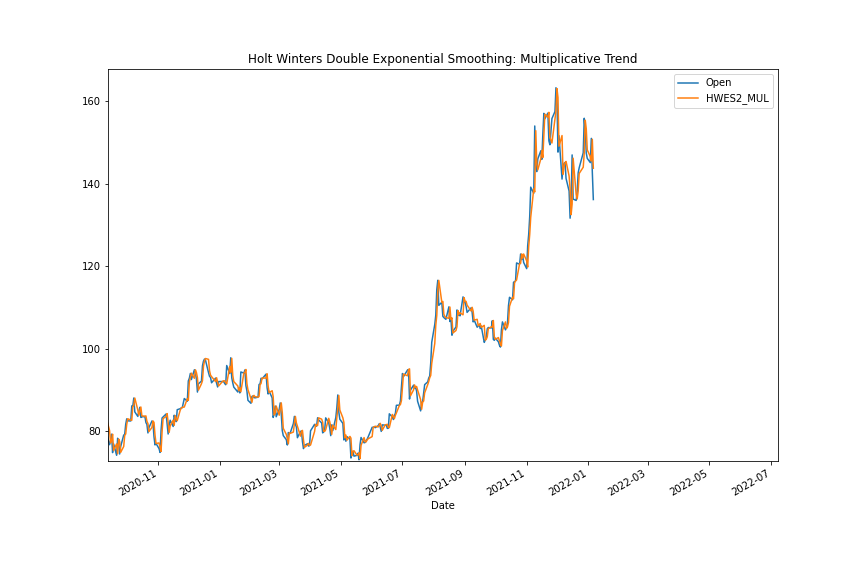

<AxesSubplot:title={'center':'Holt Winters Double Exponential Smoothing: Multiplicative Trend'}, xlabel='Date'>

In [12]:
AMD['HWES2_ADD'] = ExponentialSmoothing(AMD['Open'],trend='add').fit().fittedvalues
AMD['HWES2_MUL'] = ExponentialSmoothing(AMD['Open'],trend='mul').fit().fittedvalues
AMD[['Open','HWES2_ADD']].plot(figsize=(12,8),title='Holt Winters Double Exponential Smoothing: Additive Trend')
AMD[['Open','HWES2_MUL']].plot(figsize=(12,8),title='Holt Winters Double Exponential Smoothing: Multiplicative Trend')

<IPython.core.display.Javascript object>


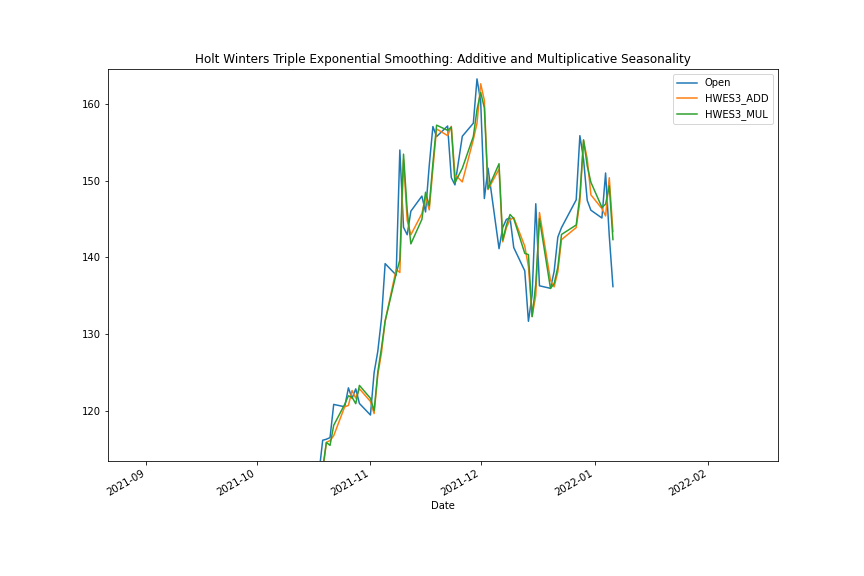

<AxesSubplot:title={'center':'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='Date'>

In [13]:
AMD['HWES3_ADD'] = ExponentialSmoothing(AMD['Open'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
AMD['HWES3_MUL'] = ExponentialSmoothing(AMD['Open'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
AMD[['Open','HWES3_ADD','HWES3_MUL']].plot(figsize=(12,8),title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')

In [14]:
forecast_data = pd.read_csv("AMD_Stock.csv")
forecast_data.index.freq = 'd'
train_AMD = forecast_data[:2000]
test_AMD = forecast_data[2000:]
%matplotlib inline
column_names = ['MAE','MSE','SQRT_MSE']  
optimal_seasonal_period = pd.DataFrame(columns=column_names)

In [16]:
def best_seasonal_period(seasonal_periods):
    for x in range(2, seasonal_periods):
        fitted_model = ExponentialSmoothing(train_AMD['Open'],trend='mul',seasonal='mul',seasonal_periods=x).fit()
        test_predictions = fitted_model.forecast(516)
        test_AMD_MAE = test_AMD['Open']
        optimal_seasonal_period.loc[x] = [mean_absolute_error(test_AMD_MAE,test_predictions),
                                          mean_squared_error(test_AMD_MAE,test_predictions),
                                          math.sqrt(mean_squared_error(test_AMD_MAE,test_predictions))]
best_seasonal_period(250);

In [19]:
print(optimal_seasonal_period)
print(optimal_seasonal_period['MAE'].min())
print(optimal_seasonal_period.index[optimal_seasonal_period['MAE'] == optimal_seasonal_period['MAE'].min()])

            MAE           MSE    SQRT_MSE
2     12.369835    283.633929   16.841435
3     12.182451    275.523493   16.598900
4     12.233446    277.466568   16.657328
5     12.520241    289.903257   17.026546
6     12.391579    284.440609   16.865367
..          ...           ...         ...
245   16.509359    469.577743   21.669743
246   41.761066   2824.588319   53.146856
247   32.709090   1687.998060   41.085254
248   50.655948   4142.770141   64.364355
249  185.038466  55310.207464  235.181223

[248 rows x 3 columns]
9.789763549337456
Int64Index([72], dtype='int64')


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

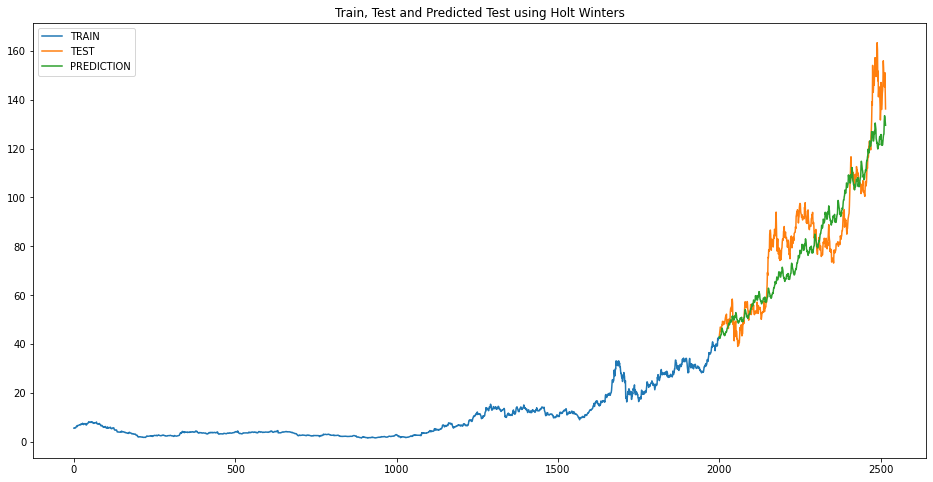

In [42]:
%matplotlib inline
fitted_model = ExponentialSmoothing(train_AMD['Open'],trend='mul',seasonal='mul',seasonal_periods=72).fit()
test_predictions = fitted_model.forecast(516)
train_AMD['Open'].plot(legend=True,label='TRAIN')
test_AMD['Open'].plot(legend=True,label='TEST',figsize=(16,8))
test_predictions.plot(legend=True,label='PREDICTION')

plt.title('Train, Test and Predicted Test using Holt Winters')


<AxesSubplot:>

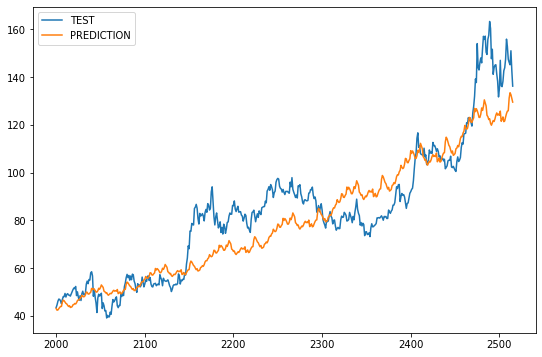

In [43]:
test_AMD['Open'].plot(legend=True,label='TEST',figsize=(9,6))
test_predictions.plot(legend=True,label='PREDICTION')

In [44]:
test_AMD_MAE = test_AMD['Open']
mean = test_AMD['Open'].mean()
print(f'Mean Absolute Error = {mean_absolute_error(test_AMD_MAE,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_AMD_MAE,test_predictions)}')
print(f'Root Mean Squared Error = {math.sqrt(mean_squared_error(test_AMD_MAE,test_predictions))}')
print('Mean =' , mean)

Mean Absolute Error = 9.789763549337456
Mean Squared Error = 149.68676057013775
Root Mean Squared Error = 12.234654084613007
Mean = 83.27823635958886
